In [6]:
!jupyter nbconvert --to script Causality.ipynb

[NbConvertApp] Converting notebook Causality.ipynb to script
[NbConvertApp] Writing 48900 bytes to Causality.py


In [10]:
!pipreqs . --force

INFO: Not scanning for jupyter notebooks.
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\bb23u\AppData\Local\anaconda3\Scripts\pipreqs.exe\__main__.py", line 7, in <module>
  File "C:\Users\bb23u\AppData\Local\anaconda3\Lib\site-packages\pipreqs\pipreqs.py", line 609, in main
    init(args)
  File "C:\Users\bb23u\AppData\Local\anaconda3\Lib\site-packages\pipreqs\pipreqs.py", line 599, in init
    generate_requirements_file(path, imports, symbol)
  File "C:\Users\bb23u\AppData\Local\anaconda3\Lib\site-packages\pipreqs\pipreqs.py", line 209, in generate_requirements_file
    with _open(path, "w") as out_file:
  File "C:\Users\bb23u\AppData\Local\anaconda3\Lib\contextlib.py", line 137, in __enter__
    return next(self.gen)
           ^^^^^^^^^^^^^^
  File "C:\Users\bb23u\AppData\Local\anaconda3\Lib\site-packages\pipreqs\pipreqs.py", line 91, in _open
    file = open(filename, mod

In [9]:
!pip freeze > requirements_new.txt

In [39]:
import pandas as pd
import random

# --------------------------------------------------------------------------------
# 1) REFERENCE RANGES & CAUSAL FACTORS
# --------------------------------------------------------------------------------
reference_ranges = {
    "Hemoglobin A1c (HbA1c)": (4.0, 6.5),
    "Creatinine": (0.6, 1.3),
    "Vitamin D (25-hydroxyvitamin D)": (20, 50),
    "C-Reactive Protein (CRP)": (0.0, 3.0),
    "Cortisol": (5, 25),
    "Low-Density Lipoprotein (LDL)": (50, 160),
    "High-Density Lipoprotein (HDL)": (40, 60),
    "Albumin": (3.5, 5.5),
}

# Original provided causal factors strings (we will filter these based on allowed_factors)
lab_tests_causal_factors = {
    "Hemoglobin A1c (HbA1c)": "Age,Gender,Obesity,Smoking,Physical activity,Medication use",
    "Creatinine": "Age,Gender,Hydration status,High protein intake,Kidney disease,Hypertension,Diabetes,Medication use",
    "Vitamin D (25-hydroxyvitamin D)": "Sunlight exposure,Diet,Ethnicity,Age,Gender,Lifestyle,Medication use",
    "C-Reactive Protein (CRP)": "Smoking,Obesity,Infections,Autoimmune diseases,Cardiovascular disease,Medication use",
    "Cortisol": "Stress,Sleep deprivation,Chronic illness,Age,Gender,Mental health,Medication use",
    "Low-Density Lipoprotein (LDL)": "Diet,Genetics,Obesity,Smoking,Lack of exercise,Diabetes,Medication use",
    "High-Density Lipoprotein (HDL)": "Diet,Genetics,Physical activity,Alcohol consumption,Smoking,Medication use",
    "Albumin": "Diet,Hydration,Liver disease,Kidney disease,Inflammation,Infection,Medication use"
}

# --------------------------------------------------------------------------------
# 2) ALLOWED CAUSAL FACTORS & PREFERRED FACTORS
# --------------------------------------------------------------------------------
# Define which factors make sense for each lab test.
allowed_factors = {
    "hemoglobin a1c (hba1c)": ["age", "gender", "obesity", "smoking", "physical activity", "medication use"],
    "creatinine": ["age", "gender", "hydration status", "high protein intake", "kidney disease", "hypertension", "diabetes", "medication use"],
    "vitamin d (25-hydroxyvitamin d)": ["age", "gender", "ethnicity", "lifestyle", "medication use"],  # Exclude diet and sunlight exposure
    "c-reactive protein (crp)": ["smoking", "obesity", "infections", "autoimmune diseases", "cardiovascular disease", "medication use"],
    "cortisol": ["stress", "sleep deprivation", "chronic illness", "age", "gender", "mental health", "medication use"],
    "low-density lipoprotein (ldl)": ["age", "gender", "obesity", "smoking", "lack of exercise", "diabetes", "medication use"],
    "high-density lipoprotein (hdl)": ["age", "gender", "medication use", "smoking", "physical activity", "alcohol consumption"],
    "albumin": ["age", "gender", "hydration", "kidney disease", "inflammation", "infection", "medication use", "liver disease"]
}
# Preferred factors to use first (if available)
preferred_factors = ["age", "gender", "smoking"]

# --------------------------------------------------------------------------------
# 3) NATURAL-LANGUAGE MAPPINGS FOR CONTROL & INTERVENTION
# --------------------------------------------------------------------------------
control_mapping = {
    "obesity": "not obese",
    "hydration status": "drinking enough water",
    "hydration": "drinking enough water",
    "smoking": "non-smoker",
    "physical activity": "active",
    "medication use": "not on medication",
    "high protein intake": "with moderate protein intake",
    "kidney disease": "with normal kidney function",
    "hypertension": "with normal blood pressure",
    "diabetes": "non-diabetic",
    "ethnicity": "of a certain ethnicity",
    "lifestyle": "with an active lifestyle",  # Note: for Vitamin D we avoid diet and sunlight exposure
    "stress": "in a relaxed state",
    "sleep deprivation": "with adequate sleep",
    "chronic illness": "without a chronic illness",
    "mental health": "with stable mental health",
    "lack of exercise": "physically active",
    "alcohol consumption": "a non-drinker",
    "inflammation": "without inflammation",
    "infection": "without infection",
    "liver disease": "with a healthy liver",
    "age": "of a younger age"
}

intervention_mapping = {
    "obesity": "exercise",
    "hydration status": "starts drinking more water",
    "hydration": "starts drinking more water",
    "smoking": "quits smoking",
    "physical activity": "starts exercising regularly",
    "medication use": "adjusts medication",  # This will be modified based on baseline status.
    "high protein intake": "reduces protein intake",
    "kidney disease": "undergoes kidney function management",
    "hypertension": "controls blood pressure",
    "diabetes": "improves glycemic control",
    "ethnicity": "undergoes an ethnicity-related intervention",
    "lifestyle": "adopts a healthier lifestyle",
    "stress": "joins a stress management program",
    "sleep deprivation": "improves sleep quality",
    "chronic illness": "manages the chronic condition",
    "mental health": "receives psychological counseling",
    "lack of exercise": "starts exercising regularly",
    "alcohol consumption": "reduces alcohol intake",
    "inflammation": "takes anti-inflammatory measures",
    "infection": "treats the infection",
    "liver disease": "manages the liver condition",
    "age": "undergoes an age-related intervention"
}

action_prefixes = ("starts", "quits", "receives", "improves", "manages", "adjusts", "adopts", "takes", "joins", "controls", "undergoes")

no_undergo_prefix = {
    "improves glycemic control",
    "increases time outdoors",
    "improves diet quality",
    "adopts a healthier lifestyle",
    "improves sleep quality",
    "manages the chronic condition",
    "receives psychological counseling",
    "reduces alcohol intake",
    "takes anti-inflammatory measures",
    "treats the infection",
    "reduces protein intake",
    "starts drinking more water"
}

# Global risk adjectives for baseline descriptions.
risk_adjectives_global = {
    "obesity": "obese",
    "smoking": "a smoker",
    "physical activity": "inactive",
    "diabetes": "diabetic",
    "hydration status": "dehydrated",
    "medication use": "",  # Handled separately.
    "high protein intake": "with high protein intake",
    "kidney disease": "with kidney disease",
    "hypertension": "with hypertension",
    "ethnicity": "of a certain ethnicity",
    "lifestyle": "with an unhealthy lifestyle",
    "stress": "under high stress",
    "sleep deprivation": "experiencing sleep deprivation",
    "chronic illness": "with a chronic illness",
    "mental health": "with poor mental health",
    "lack of exercise": "sedentary",
    "alcohol consumption": "with excessive alcohol consumption",
    "inflammation": "with inflammation",
    "infection": "with an infection",
    "liver disease": "with liver disease",
    "age": ""
}

# --------------------------------------------------------------------------------
# 4) MEDICATION DICTIONARY
# --------------------------------------------------------------------------------
medications = {
    "Hemoglobin A1c (HbA1c)": ["metformin", "glipizide", "sitagliptin", "empagliflozin"],
    "Creatinine": ["lisinopril", "losartan", "empagliflozin", "atorvastatin"],
    "Vitamin D (25-hydroxyvitamin D)": ["cholecalciferol", "ergocalciferol", "calcitriol", "paricalcitol"],
    "C-Reactive Protein (CRP)": ["atorvastatin", "rosuvastatin", "aspirin", "omega-3 fatty acids"],
    "Cortisol": ["ketoconazole", "metyrapone", "mifepristone", "cabergoline"],
    "Low-Density Lipoprotein (LDL)": ["atorvastatin", "simvastatin", "ezetimibe", "evolocumab"],
    "High-Density Lipoprotein (HDL)": ["niacin", "fenofibrate", "atorvastatin", "omega-3 fatty acids"],
    "Albumin": ["albumin infusion", "branched-chain amino acids", "L-carnitine", "zinc supplementation"]
}

# --------------------------------------------------------------------------------
# 5) HELPER FUNCTIONS
# --------------------------------------------------------------------------------
def generate_random_age():
    return random.randint(20, 80)

def generate_realistic_lab_value(lab_test, abnormal=False):
    if abnormal:
        return round(random.uniform(reference_ranges[lab_test][1] * 1.2,
                                      reference_ranges[lab_test][1] * 1.5), 1)
    return round(random.uniform(*reference_ranges[lab_test]), 1)

def generate_random_months():
    return random.randint(1, 12)

def flip_gender(gender):
    return "female" if gender.lower() == "male" else "male"

def get_pronoun(gender):
    return "his" if gender.lower() == "male" else "her"

# Mapping for counterfactual phrasing corrections.
counterfactual_phrases = {
    "obesity": "had never been obese",
    "smoking": "had never been a smoker",
    "medication use": "had never taken {}",
    "physical activity": "had never been inactive",
    "hydration status": "had never experienced dehydration",
    "high protein intake": "had never had high protein intake",
    "kidney disease": "had never developed kidney disease",
    "hypertension": "had never developed hypertension",
    "diabetes": "had never developed diabetes",
    "ethnicity": "had never been of that ethnicity",
    "lifestyle": "had never adopted an unhealthy lifestyle",
    "stress": "had never experienced excessive stress",
    "sleep deprivation": "had never experienced sleep deprivation",
    "chronic illness": "had never developed a chronic illness",
    "mental health": "had never experienced poor mental health",
    "lack of exercise": "had never been inactive",
    "alcohol consumption": "had never consumed alcohol excessively",
    "inflammation": "had never developed inflammation",
    "infection": "had never developed an infection",
    "liver disease": "had never developed liver disease",
    "age": "had never experienced age-related decline"
}

# --------------------------------------------------------------------------------
# 6) MAIN QUESTION GENERATOR WITH EXPLICIT CAUSAL FACTORS
# --------------------------------------------------------------------------------
def generate_natural_questions(lab_test, causal_factors, n_factors):
    """
    Generate Association, Intervention, and Counterfactual Reasoning questions for a lab test
    using exactly n_factors causal factors.
    """
    questions = []
    lab_key = lab_test.lower()
    # Filter allowed factors for this lab test.
    raw_factors = [f.strip().lower() for f in causal_factors.split(',')]
    allowed_list = [f for f in raw_factors if f in allowed_factors.get(lab_key, [])]
    if not allowed_list:
        allowed_list = raw_factors

    # For single-factor sets, try to pick one from preferred factors.
    if n_factors == 1:
        preferred_options = [f for f in allowed_list if f in preferred_factors]
        if preferred_options:
            selected_factors = [random.choice(preferred_options)]
        else:
            selected_factors = random.sample(allowed_list, 1)
    else:
        # For 2 or 3 factors, ensure at least one preferred factor if available.
        preferred_options = [f for f in allowed_list if f in preferred_factors]
        selected_factors = []
        if preferred_options:
            selected_factors.append(random.choice(preferred_options))
        remaining_needed = n_factors - len(selected_factors)
        remaining_options = [f for f in allowed_list if f not in selected_factors]
        if remaining_options and len(remaining_options) >= remaining_needed:
            selected_factors.extend(random.sample(remaining_options, remaining_needed))
        else:
            selected_factors.extend(remaining_options)
            while len(selected_factors) < n_factors:
                selected_factors.append(random.choice(allowed_list))
    factors_text = ", ".join(selected_factors)
    
    # For medication use, decide baseline status (for Intervention only).
    baseline_med_status = None
    if "medication use" in selected_factors:
        baseline_med_status = random.choice([True, False])
        # Also decide on a drug name.
        possible_meds = medications.get(lab_test, [])
        medication_name = random.choice(possible_meds) if possible_meds else "medication"
    else:
        medication_name = None
    
    # -------------------------
    # 1) Association Question
    # -------------------------
    older_age = random.randint(50, 80)
    younger_age = random.randint(20, 40)
    gender_high = random.choice(["male", "female"])
    gender_low = random.choice(["male", "female"])
    
    risk_desc_parts = []
    for f in selected_factors:
        if f in ["age", "gender"]:
            continue
        if f == "medication use":
            # For Association, simply use a fixed phrasing.
            term = f"taking {medication_name}" if medication_name else "on medication"
        else:
            term = risk_adjectives_global.get(f, f)
        risk_desc_parts.append(term)
    risk_desc = " and ".join(risk_desc_parts)
    
    control_desc_parts = []
    for f in selected_factors:
        if f in ["age", "gender"]:
            continue
        control_term = control_mapping.get(f, f)
        control_desc_parts.append(control_term)
    control_desc = " and ".join(control_desc_parts)
    
    normal_value = generate_realistic_lab_value(lab_test, abnormal=False)
    assoc_question = (
        f"Does a {older_age}-year-old {gender_high} {risk_desc} with {lab_test} = {normal_value} "
        f"have a higher {lab_test} level than a {younger_age}-year-old {gender_low} {control_desc}?"
    )
    questions.append({
        "Lab Test": lab_test,
        "Causal Type": "Association",
        "Question": assoc_question,
        "Causal factors": factors_text
    })
    
    # -------------------------
    # 2) Intervention Question
    # -------------------------
    age_int = random.randint(40, 80)
    gender_int = random.choice(["male", "female"])
    abnormal_value = generate_realistic_lab_value(lab_test, abnormal=True)
    
    # Choose an intervention factor – pick the first non-demographic factor
    intervention_factor = None
    for f in selected_factors:
        if f not in ["age", "gender"]:
            intervention_factor = f
            break
    if intervention_factor is None:
        intervention_factor = selected_factors[0]
    
    # Build baseline risk description for Intervention excluding the intervention factor.
    risk_desc_int_parts = []
    for f in selected_factors:
        if f in ["age", "gender"] or f == intervention_factor:
            continue
        if f == "medication use":
            risk_desc_int_parts.append("taking " + (medication_name if medication_name else "medication"))
        else:
            risk_desc_int_parts.append(risk_adjectives_global.get(f, f))
    risk_desc_int = " and ".join(risk_desc_int_parts)
    if risk_desc_int:
        risk_desc_int = "who is " + risk_desc_int
    else:
        risk_desc_int = ""
    
    # Determine intervention text.
    if intervention_factor == "medication use":
        if baseline_med_status:
            intervention_text = f"adjusts the dosage of {medication_name}"
            baseline_phrase = f"who is already taking {medication_name}"
        else:
            intervention_text = f"starts taking {medication_name}"
            baseline_phrase = "who is not on medication"
        risk_desc_int = baseline_phrase
    else:
        intervention_phrase = intervention_mapping.get(intervention_factor, f"{intervention_factor} intervention")
        if not intervention_phrase.lower().startswith(action_prefixes):
            intervention_text = f"undergoes {intervention_phrase}"
        else:
            intervention_text = intervention_phrase
    
    months = generate_random_months()
    month_text = "month" if months == 1 else "months"
    interv_question = (
        f"If a {age_int}-year-old {gender_int} patient with {lab_test} = {abnormal_value} {risk_desc_int}, "
        f"{intervention_text}, what is the expected change in their {lab_test} level in {months} {month_text}?"
    )
    questions.append({
        "Lab Test": lab_test,
        "Causal Type": "Intervention",
        "Question": interv_question,
        "Causal factors": factors_text
    })
    
    # -------------------------
    # 3) Counterfactual Reasoning Question
    # -------------------------
    non_demo_factors = [f for f in selected_factors if f not in ["age", "gender"]]
    if non_demo_factors:
        chosen_factor = random.choice(non_demo_factors)
    else:
        chosen_factor = selected_factors[0]
    
    if chosen_factor == "obesity":
        removal_phrase = "had never been obese"
    elif chosen_factor == "smoking":
        removal_phrase = "had never been a smoker"
    elif chosen_factor == "medication use":
        removal_phrase = f"had never taken {medication_name}" if medication_name else "had never taken medication"
    elif chosen_factor in counterfactual_phrases:
        removal_phrase = counterfactual_phrases[chosen_factor]
    else:
        removal_phrase = f"had never developed {chosen_factor}"
    
    counterfactual_question = (
        f"If this patient {removal_phrase}, would their {lab_test} still be {abnormal_value}?"
    )
    questions.append({
        "Lab Test": lab_test,
        "Causal Type": "Counterfactual Reasoning",
        "Question": counterfactual_question,
        "Causal factors": factors_text
    })
    
    return questions

# --------------------------------------------------------------------------------
# 7) EXTRA STATIC QUESTION TEMPLATES (Optional)
# --------------------------------------------------------------------------------
extra_question_templates = [
    {
        "Lab Test": "Hemoglobin A1c (HbA1c)",
        "Causal Type": "Intervention",
        "Question": "If a 52-year-old male patient with Hemoglobin A1c (HbA1c) = 9.1 who is already taking metformin adjusts the dosage of metformin, what is the expected change in his Hemoglobin A1c level over 7 months?",
        "Causal factors": "medication use"
    },
    {
        "Lab Test": "Hemoglobin A1c (HbA1c)",
        "Causal Type": "Counterfactual Reasoning",
        "Question": "If this patient had never taken metformin, would their Hemoglobin A1c still be 9.1?",
        "Causal factors": "medication use"
    },
    # ... add more static questions as needed ...
]

# --------------------------------------------------------------------------------
# 8) GENERATE QUESTIONS UNTIL WE REACH 200
# --------------------------------------------------------------------------------
all_questions = []

# For each lab test, generate sets with 1, 2, and 3 causal factors.
for lab, factors in lab_tests_causal_factors.items():
    for n in [1, 2, 3]:
        all_questions.extend(generate_natural_questions(lab, factors, n))

# If total questions are fewer than 200, keep generating additional ones.
while len(all_questions) < 200:
    lab_test = random.choice(list(lab_tests_causal_factors.keys()))
    n = random.choice([1, 2, 3])
    all_questions.extend(generate_natural_questions(lab_test, lab_tests_causal_factors[lab_test], n))

# Append extra static questions.
all_questions.extend(extra_question_templates)

# Trim to exactly 200 questions.
all_questions = all_questions[:200]

# --------------------------------------------------------------------------------
# 9) CONVERT TO DATAFRAME, SAVE, AND DISPLAY
# --------------------------------------------------------------------------------
all_questions_df = pd.DataFrame(all_questions)
all_questions_df


,Lab Test,Causal Type,Question,Causal factors
0,Hemoglobin A1c (HbA1c),Association,Does a 68-year-old female a smoker with Hemogl...,smoking
1,Hemoglobin A1c (HbA1c),Intervention,If a 61-year-old female patient with Hemoglobi...,smoking
2,Hemoglobin A1c (HbA1c),Counterfactual Reasoning,"If this patient had never been a smoker, would...",smoking
3,Hemoglobin A1c (HbA1c),Association,Does a 73-year-old male a smoker with Hemoglob...,"age, smoking"
4,Hemoglobin A1c (HbA1c),Intervention,If a 63-year-old male patient with Hemoglobin ...,"age, smoking"
...,...,...,...,...
195,Cortisol,Association,Does a 50-year-old female with a chronic illne...,"gender, chronic illness, age"
196,Cortisol,Intervention,If a 55-year-old male patient with Cortisol = ...,"gender, chronic illness, age"
197,Cortisol,Counterfactual Reasoning,If this patient had never developed a chronic ...,"gender, chronic illness, age"
198,Low-Density Lipoprotein (LDL),Association,Does a 77-year-old male a smoker and taking si...,"smoking, medication use"


In [40]:
# Save the questions as a CSV file
all_questions_df.to_csv("C:\\D\\e Health Lab projects\\Question_Answering\\LLM_Causality\\100_lab_test_questions.csv", index=False)

In [13]:
# GPT-o1 evaluation
import os
import time
import pandas as pd
import openai

# Set the API key manually
api_key = ""  # Replace with your actual key

# Initialize OpenAI client
client = openai.OpenAI(api_key=api_key)

if not client.api_key:
    raise ValueError("Please set your OPENAI_API_KEY environment variable.")

def get_model_response(prompt):
    """
    Calls the GPT-4o API with the given prompt and returns the content of the response.
    """
    try:
        response = client.chat.completions.create(
            model="gpt-4o",  # Specify the model explicitly
            messages=[{"role": "system", "content": "You are a medical professional."},
                      {"role": "user", "content": prompt}],
            temperature=0,   # Setting temperature to 0 ensures deterministic responses
            top_p=1,         # Ensures sampling is not restricted, but since temp=0, it's not used
            max_tokens=500,  # Adjust based on response length requirement
            frequency_penalty=0,  # No additional penalty for repeated phrases
            presence_penalty=0,   # No penalty for introducing new topics
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"API call error: {e}")
        return None

def main():
    # Input CSV file should have columns: 'Lab Test', 'Causal Type', 'Question', 'Causal factors'
    input_csv = "C:\\D\\e Health Lab projects\\Question_Answering\\LLM_Causality\\15_lab_test_questions.csv"
    output_tsv = "C:\\D\\e Health Lab projects\\Question_Answering\\LLM_Causality\\15_lab_test_questions_answers.tsv"

    # Read the input file
    df = pd.read_csv(input_csv)
    responses = []  # To store API responses

    # Loop through each row in the CSV file
    for index, row in df.iterrows():
        lab_test = row.get("Lab Test", "")
        causal_type = row.get("Causal Type", "")
        question = row.get("Question", "")
        causal_factors = row.get("Causal factors", "")

        # Construct the prompt for the API call
        prompt = f"""Please act as a medical professional specializing in laboratory diagnostics and clinical decision-making. Your task is to analyze causal relationships related to various laboratory markers (e.g., HbA1c, creatinine, CRP, cortisol) by assessing association, intervention effects, and counterfactual scenarios.

The question and answer format should be:
Association Q: [Question comparing two groups or conditions] A: [Yes/No/Increased/Decreased/etc.] Reasoning: [Brief explanation based on relevant risk factors, pathophysiology, or established evidence]

Intervention Q: [Question describing an intervention and its likely effect on a lab marker or clinical outcome] A: [Expected direction of change or result] Reasoning: [Explanation of how the intervention mechanistically alters the lab marker or outcome, supported by evidence or guidelines]

Counterfactual Reasoning Q: [Hypothetical scenario where a key risk factor or condition is absent or changed] A: [Yes/No/Altered outcome] Reasoning: [Explanation of how the absence or alteration of the factor would affect the outcome, based on pathophysiology or epidemiological data]

Provide the response in tab-separated format as follows:
Response\tReasoning

Example output:
Yes\tOlder age, obesity, and smoking are all associated with insulin resistance and impaired glucose metabolism, leading to elevated HbA1c levels.

Now, evaluate the following:
Lab Test: {lab_test}
Causal Type: {causal_type}
Question: {question}
Causal Factors: {causal_factors}
"""

        print(f"Processing row {index+1}/{len(df)}...")
        api_response = get_model_response(prompt)

        if api_response:
            # Ensure tab-separated response parsing
            parts = api_response.split("\t")
            if len(parts) >= 2:
                response_text, reasoning_text = parts[0].strip(), parts[1].strip()
            else:
                response_text, reasoning_text = api_response, ""
        else:
            response_text, reasoning_text = "", ""

        responses.append({"Response": response_text, "Reasoning": reasoning_text})
        
        # Respect rate limits
        time.sleep(1)

    # Create and save the updated DataFrame
    responses_df = pd.DataFrame(responses)
    combined_df = pd.concat([df, responses_df], axis=1)
    combined_df.to_csv(output_tsv, sep="\t", index=False)
    
    print(f"Results saved to {output_tsv}")

if __name__ == "__main__":
    main()


Processing row 1/15...
Processing row 2/15...
Processing row 3/15...
Processing row 4/15...
Processing row 5/15...
Processing row 6/15...
Processing row 7/15...
Processing row 8/15...
Processing row 9/15...
Processing row 10/15...
Processing row 11/15...
Processing row 12/15...
Processing row 13/15...
Processing row 14/15...
Processing row 15/15...
Results saved to C:\D\e Health Lab projects\Question_Answering\LLM_Causality\15_lab_test_questions_answers.tsv


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the data
data = {
    "LLM": ["GPT-4", "GPT-3.5", "LLaMA3", "GatorTronGPT", "GPT-4+RAG"],
    "Accuracy": [0.633, 0.431, 0.325, 0.301, 0.267]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Define a color gradient function
def color_gradient(val):
    cmap = plt.get_cmap("YlOrBr")  # Use Yellow-Orange-Brown colormap
    norm = plt.Normalize(df["Accuracy"].min(), df["Accuracy"].max())
    color = cmap(norm(val))
    return f"background-color: rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, {color[3]})"

# Apply the coloring
styled_df = df.style.applymap(color_gradient, subset=["Accuracy"])
styled_df 


,LLM,Accuracy
0,GPT-4,0.633000
1,GPT-3.5,0.431000
2,LLaMA3,0.325000
3,GatorTronGPT,0.301000
4,GPT-4+RAG,0.267000


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the data
data = {
    "LLM": ["GPT-4", "GPT-3.5", "LLaMA3", "GatorTronGPT", "GPT-4+RAG"],
    "Accuracy": [0.633, 0.431, 0.325, 0.301, 0.267]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Define a color gradient function (coolwarm)
def color_gradient(val):
    cmap = plt.get_cmap("coolwarm")  # Using blue-to-red colormap
    norm = plt.Normalize(df["Accuracy"].min(), df["Accuracy"].max())
    color = cmap(norm(val))
    return f"background-color: rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, {color[3]})"

# Apply the coloring
styled_df = df.style.applymap(color_gradient, subset=["Accuracy"])
styled_df



,LLM,Accuracy
0,GPT-4,0.633000
1,GPT-3.5,0.431000
2,LLaMA3,0.325000
3,GatorTronGPT,0.301000
4,GPT-4+RAG,0.267000


'D://gradient_colored_table.png'

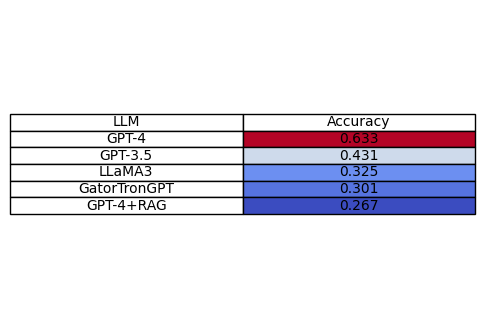

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the data
data = {
    "LLM": ["GPT-4", "GPT-3.5", "LLaMA3", "GatorTronGPT", "GPT-4+RAG"],
    "Accuracy": [0.633, 0.431, 0.325, 0.301, 0.267]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Apply heatmap-like coloring using coolwarm colormap
colors = sns.color_palette("coolwarm", as_cmap=True)
norm = plt.Normalize(df["Accuracy"].min(), df["Accuracy"].max())

# Plot table with colored background
ax.axis('tight')
ax.axis('off')
table = plt.table(cellText=df.values,
                  colLabels=df.columns,
                  cellColours=[[colors(norm(val)) if i == 1 else (1, 1, 1, 1) for i, val in enumerate(row)] for row in df.values],
                  cellLoc='center',
                  loc='center')

# Save as image
image_path = "D://gradient_colored_table.png"
plt.savefig(image_path, dpi=300, bbox_inches='tight')

# Display the saved image path
image_path


In [9]:
#Code updates version 2
import pandas as pd
import random

# --------------------------------------------------------------------------------
# 1) REFERENCE RANGES & CAUSAL FACTORS
# --------------------------------------------------------------------------------
reference_ranges = {
    "Hemoglobin A1c (HbA1c)": (4.0, 6.5),
    "Creatinine": (0.6, 1.3),
    "Vitamin D (25-hydroxyvitamin D)": (20, 50),
    "C-Reactive Protein (CRP)": (0.0, 3.0),
    "Cortisol": (5, 25),
    "Low-Density Lipoprotein (LDL)": (50, 160),
    "High-Density Lipoprotein (HDL)": (40, 60),
    "Albumin": (3.5, 5.5),
}

# Original provided causal factors strings (we will filter these based on allowed_factors)
lab_tests_causal_factors = {
    "Hemoglobin A1c (HbA1c)": "Age,Gender,Obesity,Smoking,Physical activity,Medication use",
    "Creatinine": "Age,Gender,Hydration status,High protein intake,Kidney disease,Hypertension,Diabetes,Medication use",
    "Vitamin D (25-hydroxyvitamin D)": "Sunlight exposure,Diet,Ethnicity,Age,Gender,Lifestyle,Medication use",
    "C-Reactive Protein (CRP)": "Smoking,Obesity,Infections,Autoimmune diseases,Cardiovascular disease,Medication use",
    "Cortisol": "Stress,Sleep deprivation,Chronic illness,Age,Gender,Mental health,Medication use",
    "Low-Density Lipoprotein (LDL)": "Diet,Genetics,Obesity,Smoking,Lack of exercise,Diabetes,Medication use",
    "High-Density Lipoprotein (HDL)": "Diet,Genetics,Physical activity,Alcohol consumption,Smoking,Medication use",
    "Albumin": "Diet,Hydration,Liver disease,Kidney disease,Inflammation,Infection,Medication use"
}

# --------------------------------------------------------------------------------
# 2) ALLOWED CAUSAL FACTORS & PREFERRED FACTORS
# --------------------------------------------------------------------------------
# Define which factors make sense for each lab test.
allowed_factors = {
    "hemoglobin a1c (hba1c)": ["age", "gender", "obesity", "smoking", "physical activity", "medication use"],
    "creatinine": ["age", "gender", "hydration status", "high protein intake", "kidney disease", "hypertension", "diabetes", "medication use"],
    "vitamin d (25-hydroxyvitamin d)": ["age", "gender", "ethnicity", "lifestyle", "medication use"],  # Exclude diet and sunlight exposure
    "c-reactive protein (crp)": ["smoking", "obesity", "infections", "autoimmune diseases", "cardiovascular disease", "medication use"],
    "cortisol": ["stress", "sleep deprivation", "chronic illness", "age", "gender", "mental health", "medication use"],
    "low-density lipoprotein (ldl)": ["age", "gender", "obesity", "smoking", "lack of exercise", "diabetes", "medication use"],
    "high-density lipoprotein (hdl)": ["age", "gender", "medication use", "smoking", "physical activity", "alcohol consumption"],
    "albumin": ["age", "gender", "hydration", "kidney disease", "inflammation", "infection", "medication use", "liver disease"]
}
# Preferred factors to use first (if available)
preferred_factors = ["age", "gender", "smoking"]

# Set of modifiable factors (those on which an intervention or counterfactual manipulation is plausible)
modifiable_variables = {
    "obesity", "smoking", "physical activity", "medication use", "hydration status",
    "high protein intake", "kidney disease", "hypertension", "diabetes", "ethnicity",
    "lifestyle", "stress", "sleep deprivation", "chronic illness", "mental health",
    "lack of exercise", "alcohol consumption", "inflammation", "infection", "liver disease"
}

# --------------------------------------------------------------------------------
# 3) NATURAL-LANGUAGE MAPPINGS FOR CONTROL & INTERVENTION
# --------------------------------------------------------------------------------
control_mapping = {
    "obesity": "not obese",
    "hydration status": "drinking enough water",
    "hydration": "drinking enough water",
    "smoking": "non-smoker",
    "physical activity": "active",
    "medication use": "not on medication",
    "high protein intake": "with moderate protein intake",
    "kidney disease": "with normal kidney function",
    "hypertension": "with normal blood pressure",
    "diabetes": "non-diabetic",
    "ethnicity": "of a certain ethnicity",
    "lifestyle": "with an active lifestyle",  # Note: for Vitamin D we avoid diet and sunlight exposure
    "stress": "in a relaxed state",
    "sleep deprivation": "with adequate sleep",
    "chronic illness": "without a chronic illness",
    "mental health": "with stable mental health",
    "lack of exercise": "physically active",
    "alcohol consumption": "a non-drinker",
    "inflammation": "without inflammation",
    "infection": "without infection",
    "liver disease": "with a healthy liver",
    "age": "of a younger age"
}

intervention_mapping = {
    "obesity": "exercise",
    "hydration status": "starts drinking more water",
    "hydration": "starts drinking more water",
    "smoking": "quits smoking",
    "physical activity": "starts exercising regularly",
    "medication use": "adjusts medication",  # This will be modified based on baseline status.
    "high protein intake": "reduces protein intake",
    "kidney disease": "undergoes kidney function management",
    "hypertension": "controls blood pressure",
    "diabetes": "improves glycemic control",
    "ethnicity": "undergoes an ethnicity-related intervention",
    "lifestyle": "adopts a healthier lifestyle",
    "stress": "joins a stress management program",
    "sleep deprivation": "improves sleep quality",
    "chronic illness": "manages the chronic condition",
    "mental health": "receives psychological counseling",
    "lack of exercise": "starts exercising regularly",
    "alcohol consumption": "reduces alcohol intake",
    "inflammation": "takes anti-inflammatory measures",
    "infection": "treats the infection",
    "liver disease": "manages the liver condition",
    "age": "undergoes an age-related intervention"  # This entry will be avoided since age is non-modifiable.
}

action_prefixes = ("starts", "quits", "receives", "improves", "manages", "adjusts", "adopts", "takes", "joins", "controls", "undergoes")

no_undergo_prefix = {
    "improves glycemic control",
    "increases time outdoors",
    "improves diet quality",
    "adopts a healthier lifestyle",
    "improves sleep quality",
    "manages the chronic condition",
    "receives psychological counseling",
    "reduces alcohol intake",
    "takes anti-inflammatory measures",
    "treats the infection",
    "reduces protein intake",
    "starts drinking more water"
}

# Global risk adjectives for baseline descriptions.
risk_adjectives_global = {
    "obesity": "obese",
    "smoking": "a smoker",
    "physical activity": "inactive",
    "diabetes": "diabetic",
    "hydration status": "dehydrated",
    "medication use": "",  # Handled separately.
    "high protein intake": "with high protein intake",
    "kidney disease": "with kidney disease",
    "hypertension": "with hypertension",
    "ethnicity": "of a certain ethnicity",
    "lifestyle": "with an unhealthy lifestyle",
    "stress": "under high stress",
    "sleep deprivation": "experiencing sleep deprivation",
    "chronic illness": "with a chronic illness",
    "mental health": "with poor mental health",
    "lack of exercise": "sedentary",
    "alcohol consumption": "with excessive alcohol consumption",
    "inflammation": "with inflammation",
    "infection": "with an infection",
    "liver disease": "with liver disease",
    "age": ""
}

# --------------------------------------------------------------------------------
# 4) MEDICATION DICTIONARY
# --------------------------------------------------------------------------------
medications = {
    "Hemoglobin A1c (HbA1c)": ["metformin", "glipizide", "sitagliptin", "empagliflozin"],
    "Creatinine": ["lisinopril", "losartan", "empagliflozin", "atorvastatin"],
    "Vitamin D (25-hydroxyvitamin D)": ["cholecalciferol", "ergocalciferol", "calcitriol", "paricalcitol"],
    "C-Reactive Protein (CRP)": ["atorvastatin", "rosuvastatin", "aspirin", "omega-3 fatty acids"],
    "Cortisol": ["ketoconazole", "metyrapone", "mifepristone", "cabergoline"],
    "Low-Density Lipoprotein (LDL)": ["atorvastatin", "simvastatin", "ezetimibe", "evolocumab"],
    "High-Density Lipoprotein (HDL)": ["niacin", "fenofibrate", "atorvastatin", "omega-3 fatty acids"],
    "Albumin": ["albumin infusion", "branched-chain amino acids", "L-carnitine", "zinc supplementation"]
}

# --------------------------------------------------------------------------------
# 5) HELPER FUNCTIONS
# --------------------------------------------------------------------------------
def generate_random_age():
    return random.randint(20, 80)

def generate_realistic_lab_value(lab_test, abnormal=False):
    if abnormal:
        return round(random.uniform(reference_ranges[lab_test][1] * 1.2,
                                      reference_ranges[lab_test][1] * 1.5), 1)
    return round(random.uniform(*reference_ranges[lab_test]), 1)

def generate_random_months():
    return random.randint(1, 12)

def flip_gender(gender):
    return "female" if gender.lower() == "male" else "male"

def get_pronoun(gender):
    return "his" if gender.lower() == "male" else "her"

# Mapping for counterfactual phrasing corrections.
counterfactual_phrases = {
    "obesity": "had never been obese",
    "smoking": "had never been a smoker",
    "medication use": "had never taken {}",
    "physical activity": "had never been inactive",
    "hydration status": "had never experienced dehydration",
    "high protein intake": "had never had high protein intake",
    "kidney disease": "had never developed kidney disease",
    "hypertension": "had never developed hypertension",
    "diabetes": "had never developed diabetes",
    "ethnicity": "had never been of that ethnicity",
    "lifestyle": "had never adopted an unhealthy lifestyle",
    "stress": "had never experienced excessive stress",
    "sleep deprivation": "had never experienced sleep deprivation",
    "chronic illness": "had never developed a chronic illness",
    "mental health": "had never experienced poor mental health",
    "lack of exercise": "had never been inactive",
    "alcohol consumption": "had never consumed alcohol excessively",
    "inflammation": "had never developed inflammation",
    "infection": "had never developed an infection",
    "liver disease": "had never developed liver disease",
    "age": "had never experienced age-related decline"  # Will be avoided for interventions.
}

# --------------------------------------------------------------------------------
# 6) MAIN QUESTION GENERATOR WITH EXPLICIT CAUSAL FACTORS
# --------------------------------------------------------------------------------
def generate_natural_questions(lab_test, causal_factors, n_factors):
    """
    Generate Association, Intervention, and Counterfactual Reasoning questions for a lab test
    using exactly n_factors causal factors.
    """
    questions = []
    lab_key = lab_test.lower()
    # Filter allowed factors for this lab test.
    raw_factors = [f.strip().lower() for f in causal_factors.split(',')]
    allowed_list = [f for f in raw_factors if f in allowed_factors.get(lab_key, [])]
    if not allowed_list:
        allowed_list = raw_factors

    # For single-factor sets, try to pick one from preferred factors.
    if n_factors == 1:
        preferred_options = [f for f in allowed_list if f in preferred_factors]
        if preferred_options:
            selected_factors = [random.choice(preferred_options)]
        else:
            selected_factors = random.sample(allowed_list, 1)
    else:
        # For 2 or 3 factors, ensure at least one preferred factor if available.
        preferred_options = [f for f in allowed_list if f in preferred_factors]
        selected_factors = []
        if preferred_options:
            selected_factors.append(random.choice(preferred_options))
        remaining_needed = n_factors - len(selected_factors)
        remaining_options = [f for f in allowed_list if f not in selected_factors]
        if remaining_options and len(remaining_options) >= remaining_needed:
            selected_factors.extend(random.sample(remaining_options, remaining_needed))
        else:
            selected_factors.extend(remaining_options)
            while len(selected_factors) < n_factors:
                selected_factors.append(random.choice(allowed_list))
    factors_text = ", ".join(selected_factors)
    
    # For medication use, decide baseline status (for Intervention only).
    baseline_med_status = None
    if "medication use" in selected_factors:
        baseline_med_status = random.choice([True, False])
        possible_meds = medications.get(lab_test, [])
        medication_name = random.choice(possible_meds) if possible_meds else "medication"
    else:
        medication_name = None
    
    # -------------------------
    # 1) Association Question
    # -------------------------
    older_age = random.randint(50, 80)
    younger_age = random.randint(20, 40)
    gender_high = random.choice(["male", "female"])
    gender_low = random.choice(["male", "female"])
    
    risk_desc_parts = []
    for f in selected_factors:
        if f in ["age", "gender"]:
            continue
        if f == "medication use":
            term = f"taking {medication_name}" if medication_name else "on medication"
        else:
            term = risk_adjectives_global.get(f, f)
        risk_desc_parts.append(term)
    risk_desc = " and ".join(risk_desc_parts)
    
    control_desc_parts = []
    for f in selected_factors:
        if f in ["age", "gender"]:
            continue
        control_term = control_mapping.get(f, f)
        control_desc_parts.append(control_term)
    control_desc = " and ".join(control_desc_parts)
    
    normal_value = generate_realistic_lab_value(lab_test, abnormal=False)
    assoc_question = (
        f"Does a {older_age}-year-old {gender_high} {risk_desc} with {lab_test} = {normal_value} "
        f"have a higher {lab_test} level than a {younger_age}-year-old {gender_low} {control_desc}?"
    )
    questions.append({
        "Lab Test": lab_test,
        "Causal Type": "Association",
        "Question": assoc_question,
        "Causal factors": factors_text
    })
    
    # -------------------------
    # 2) Intervention Question
    # -------------------------
    # Only use modifiable factors (exclude age and gender)
    modifiable_candidates = [f for f in selected_factors if f not in ["age", "gender"] and f in modifiable_variables]
    if not modifiable_candidates:
        # No valid intervention factor; fall back to an association-like intervention question.
        interv_question = assoc_question.replace("have a higher", "have a different")
        questions.append({
            "Lab Test": lab_test,
            "Causal Type": "Intervention",
            "Question": interv_question,
            "Causal factors": factors_text
        })
    else:
        intervention_factor = modifiable_candidates[0]
    
        age_int = random.randint(40, 80)
        gender_int = random.choice(["male", "female"])
        abnormal_value = generate_realistic_lab_value(lab_test, abnormal=True)
        
        # Build baseline risk description for Intervention excluding the intervention factor.
        risk_desc_int_parts = []
        for f in selected_factors:
            if f in ["age", "gender"] or f == intervention_factor:
                continue
            if f == "medication use":
                risk_desc_int_parts.append("taking " + (medication_name if medication_name else "medication"))
            else:
                risk_desc_int_parts.append(risk_adjectives_global.get(f, f))
        risk_desc_int = " and ".join(risk_desc_int_parts)
        if risk_desc_int:
            risk_desc_int = "who is " + risk_desc_int
        else:
            risk_desc_int = ""
    
        # Determine intervention text.
        if intervention_factor == "medication use":
            if baseline_med_status:
                intervention_text = f"adjusts the dosage of {medication_name}"
                risk_desc_int = f"who is already taking {medication_name}"
            else:
                intervention_text = f"starts taking {medication_name}"
                risk_desc_int = "who is not on medication"
        else:
            intervention_phrase = intervention_mapping.get(intervention_factor, f"{intervention_factor} intervention")
            if not intervention_phrase.lower().startswith(action_prefixes):
                intervention_text = f"undergoes {intervention_phrase}"
            else:
                intervention_text = intervention_phrase
    
        months = generate_random_months()
        month_text = "month" if months == 1 else "months"
        interv_question = (
            f"If a {age_int}-year-old {gender_int} patient with {lab_test} = {abnormal_value} {risk_desc_int}, "
            f"{intervention_text}, what is the expected change in their {lab_test} level in {months} {month_text}?"
        )
        questions.append({
            "Lab Test": lab_test,
            "Causal Type": "Intervention",
            "Question": interv_question,
            "Causal factors": factors_text
        })
    
    # -------------------------
    # 3) Counterfactual Reasoning Question
    # -------------------------
    # Only allow counterfactuals on modifiable factors.
    modifiable_cf_candidates = [f for f in selected_factors if f not in ["age", "gender"] and f in modifiable_variables]
    if not modifiable_cf_candidates:
        # Fall back to an association-like counterfactual phrasing.
        counterfactual_question = assoc_question.replace("have a higher", "have a different")
    else:
        chosen_factor = random.choice(modifiable_cf_candidates)
        if chosen_factor == "obesity":
            removal_phrase = "had never been obese"
        elif chosen_factor == "smoking":
            removal_phrase = "had never been a smoker"
        elif chosen_factor == "medication use":
            removal_phrase = f"had never taken {medication_name}" if medication_name else "had never taken medication"
        elif chosen_factor in counterfactual_phrases:
            removal_phrase = counterfactual_phrases[chosen_factor]
        else:
            removal_phrase = f"had never developed {chosen_factor}"
    
        counterfactual_question = (
            f"If this patient {removal_phrase}, would their {lab_test} still be {abnormal_value}?"
        )
    questions.append({
        "Lab Test": lab_test,
        "Causal Type": "Counterfactual Reasoning",
        "Question": counterfactual_question,
        "Causal factors": factors_text
    })
    
    return questions

# --------------------------------------------------------------------------------
# 7) EXTRA STATIC QUESTION TEMPLATES (Optional)
# --------------------------------------------------------------------------------
extra_question_templates = [
    {
        "Lab Test": "Hemoglobin A1c (HbA1c)",
        "Causal Type": "Intervention",
        "Question": "If a 52-year-old male patient with Hemoglobin A1c (HbA1c) = 9.1 who is already taking metformin adjusts the dosage of metformin, what is the expected change in his Hemoglobin A1c level over 7 months?",
        "Causal factors": "medication use"
    },
    {
        "Lab Test": "Hemoglobin A1c (HbA1c)",
        "Causal Type": "Counterfactual Reasoning",
        "Question": "If this patient had never taken metformin, would their Hemoglobin A1c still be 9.1?",
        "Causal factors": "medication use"
    },
    # ... add more static questions as needed ...
]

# --------------------------------------------------------------------------------
# 8) GENERATE QUESTIONS UNTIL WE REACH 200
# --------------------------------------------------------------------------------
all_questions = []

# For each lab test, generate sets with 1, 2, and 3 causal factors.
for lab, factors in lab_tests_causal_factors.items():
    for n in [1, 2, 3]:
        all_questions.extend(generate_natural_questions(lab, factors, n))

# If total questions are fewer than 200, keep generating additional ones.
while len(all_questions) < 200:
    lab_test = random.choice(list(lab_tests_causal_factors.keys()))
    n = random.choice([1, 2, 3])
    all_questions.extend(generate_natural_questions(lab_test, lab_tests_causal_factors[lab_test], n))

# Append extra static questions.
all_questions.extend(extra_question_templates)

# Trim to exactly 200 questions.
all_questions = all_questions[:50]

# --------------------------------------------------------------------------------
# 9) CONVERT TO DATAFRAME, SAVE, AND DISPLAY
# --------------------------------------------------------------------------------
all_questions_df = pd.DataFrame(all_questions)
all_questions_df


,Lab Test,Causal Type,Question,Causal factors
0,Hemoglobin A1c (HbA1c),Association,Does a 75-year-old male a smoker with Hemoglob...,smoking
1,Hemoglobin A1c (HbA1c),Intervention,If a 78-year-old female patient with Hemoglobi...,smoking
2,Hemoglobin A1c (HbA1c),Counterfactual Reasoning,"If this patient had never been a smoker, would...",smoking
3,Hemoglobin A1c (HbA1c),Association,Does a 65-year-old male a smoker and inactive ...,"smoking, physical activity"
4,Hemoglobin A1c (HbA1c),Intervention,If a 74-year-old male patient with Hemoglobin ...,"smoking, physical activity"
5,Hemoglobin A1c (HbA1c),Counterfactual Reasoning,"If this patient had never been a smoker, would...","smoking, physical activity"
6,Hemoglobin A1c (HbA1c),Association,Does a 57-year-old female a smoker with Hemogl...,"gender, smoking, age"
7,Hemoglobin A1c (HbA1c),Intervention,If a 59-year-old male patient with Hemoglobin ...,"gender, smoking, age"
8,Hemoglobin A1c (HbA1c),Counterfactual Reasoning,"If this patient had never been a smoker, would...","gender, smoking, age"
9,Creatinine,Association,Does a 76-year-old female with Creatinine = 1...,gender


In [10]:
# Save the questions as a CSV file
all_questions_df.to_csv("C:\\D\\e Health Lab projects\\Question_Answering\\LLM_Causality\\50_lab_test_questions.csv", index=False)

In [5]:
!pip install --upgrade openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.10
    Uninstalling openpyxl-3.0.10:
      Successfully uninstalled openpyxl-3.0.10


In [9]:
import pandas as pd

df=pd.read_excel("C:\\D\\e Health Lab projects\\Question_Answering\\LLM_Causality\\Comparison.xlsx")
df



,Rung,Prediction,Outcome,GPT-o1,Llama 3.2
0,Association,1,Increased,Increased,Yes
1,Intervention,1,Decreased,Decreased,Decreased
2,Counterfactual Reasoning,0,Altered outcome,Altered outcome,Decreased
3,Association,1,No,No,No
4,Intervention,1,Decreased,Decreased,Decreased
...,...,...,...,...,...
94,Intervention,1,Decreased,Decreased,Decreased
95,Counterfactual Reasoning,0,Altered outcome,Altered outcome,No
96,Association,1,Increased,Increased,Yes
97,Intervention,1,Decreased,Decreased,Decreased


In [10]:
# Function to compute agreement rate: fraction of predictions that are 1
def agreement_rate(series):
    return series.sum() / series.count()

# Group by 'Rung' and then 'Outcome'
grouped_agreement = df.groupby(['Rung', 'Outcome']).agg(
    agreement_rate=('Prediction', agreement_rate),
    count=('Prediction', 'count')
).reset_index()

print("Agreement Rates by Rung and Outcome:")
print(grouped_agreement)

Agreement Rates by Rung and Outcome:
                        Rung                Outcome  agreement_rate  count
0                Association              Decreased        0.000000      5
1                Association              Increased        0.555556      9
2                Association                     No        1.000000      9
3                Association                    Yes        0.600000     10
4   Counterfactual Reasoning        Altered outcome        0.041667     24
5   Counterfactual Reasoning                     No        1.000000      1
6   Counterfactual Reasoning                    Yes        0.750000      8
7               Intervention        Altered outcome        0.000000      1
8               Intervention              Decreased        0.909091     22
9               Intervention              Increased        0.857143      7
10              Intervention  No significant change        0.500000      2
11              Intervention                    Yes        0.00